In [ ]:
!pip install tensorflow==2.15.1 tf-keras==2.15 scikit-learn==1.2.2 imbalanced-learn==0.12.4 numpy==1.26.4 pandas==1.5.3

In [41]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
#from keras.utils import np_utils
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2

In [ ]:
!pip show tensorflow keras imbalanced-learn scikit-learn

In [43]:
data = pd.read_csv('fer2013.csv')
data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


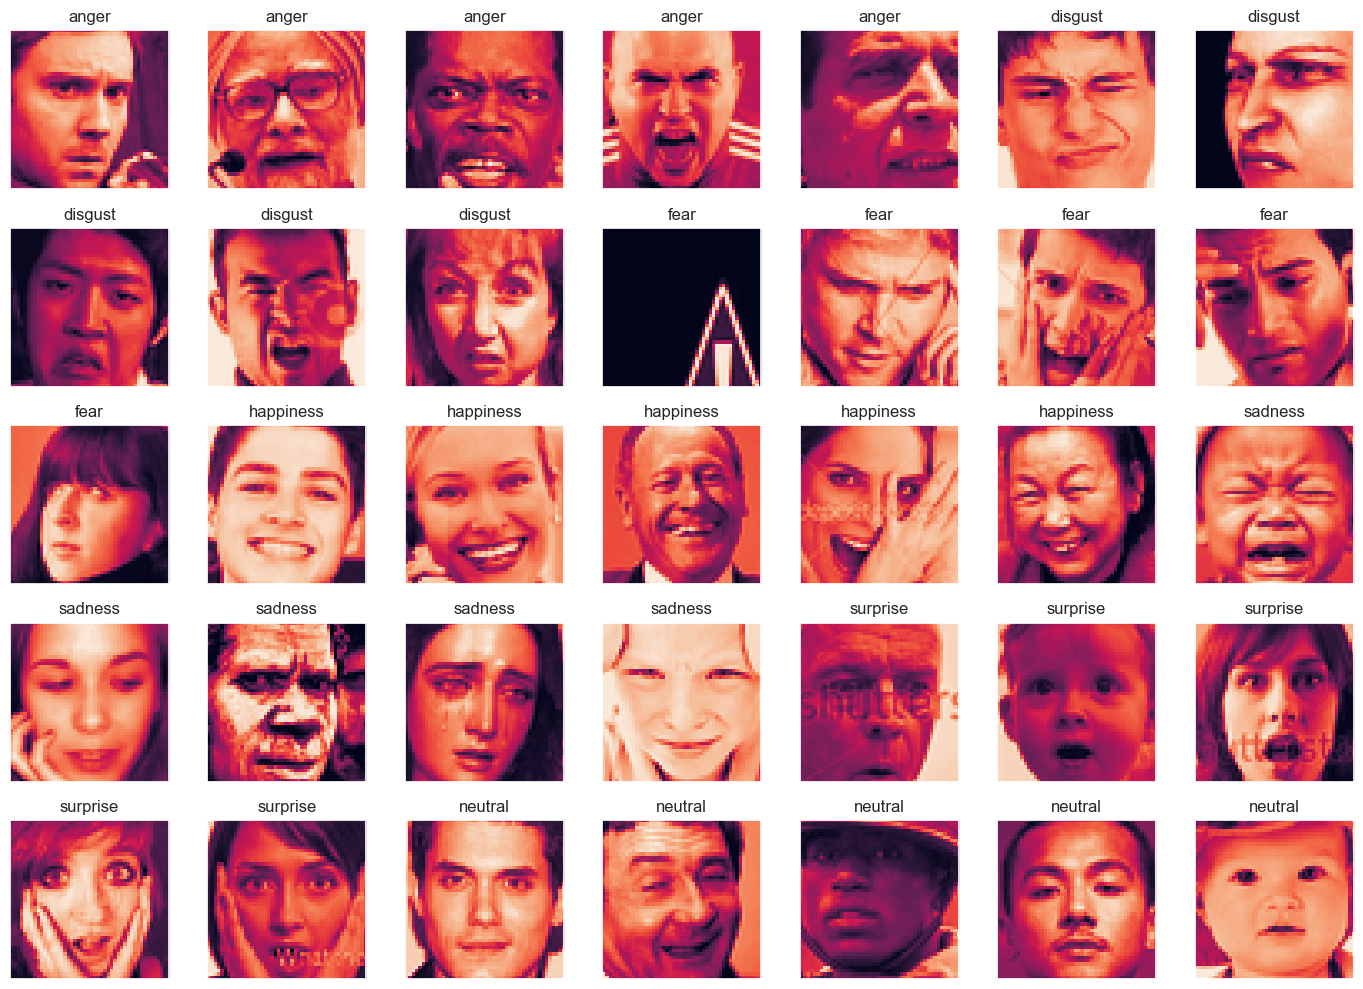

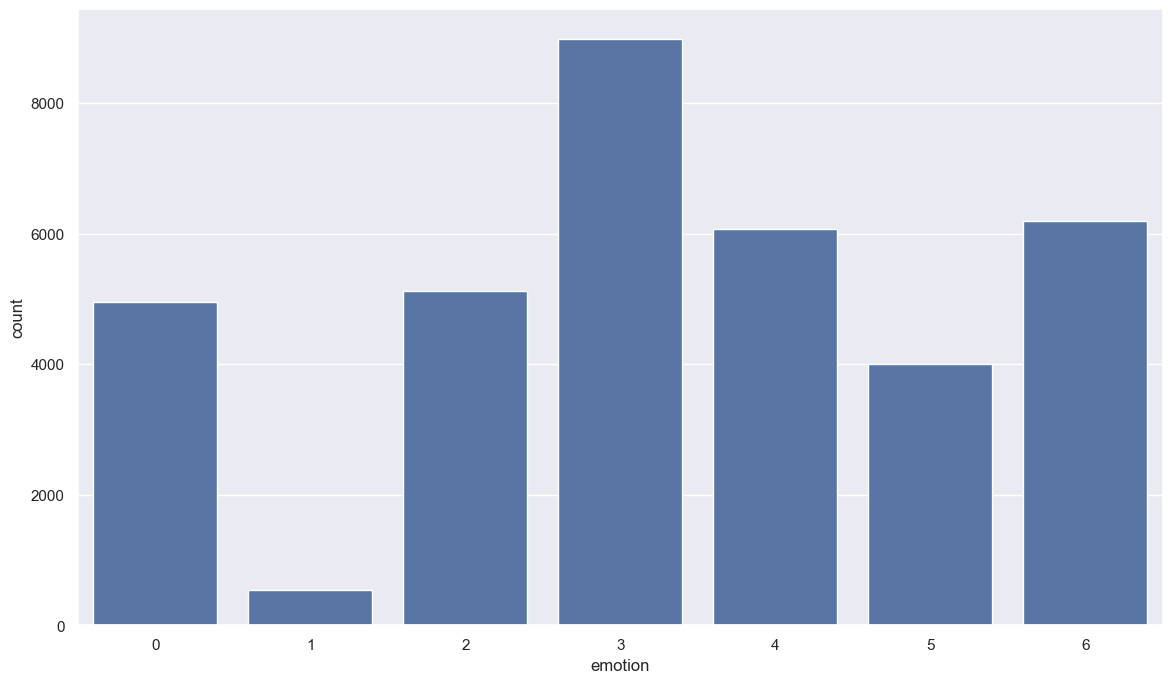

In [44]:
label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
label_to_text

fig = plt.figure(1, (14, 14))
k = 0
for label in sorted(data.emotion.unique()):
    for j in range(5):
        px = data[data.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        plt.tight_layout()

plt.figure(figsize=(14, 8))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=data)

In [45]:
# Split the data into feature & target variable
x_data = data['pixels']
y_data = data['emotion']

In [ ]:
# Perform Random Over Sampling to balance the data
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)


y_data.value_counts()


(62923, 1)   (62923,)


0    8989
2    8989
4    8989
6    8989
3    8989
5    8989
1    8989
Name: emotion, dtype: int64

In [ ]:
x_data = pd.Series(x_data.flatten())
x_data

# Normalize the data
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:10]

# Reshaping
x_data = x_data.reshape(-1, 48, 48, 1)
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)
     
x_train.shape, x_test.shape, y_train.shape, y_test.shape


((56630, 48, 48, 1), (6293, 48, 48, 1), (56630, 1), (6293, 1))

In [52]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train,7)
y_test = to_categorical(y_test,7)

In [53]:
model = Sequential([
    # 1st Conv Layer
    Input((48, 48, 1)),
    Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 2nd Conv Layer
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 3rd Conv Layer
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 4th Conv Layer
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 5th Conv Layer
    Conv2D(256, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # Flattening the Layer
    Flatten(),

    # Hidden Layer
    Dense(128, activation='relu'),
    Dropout(0.25),
    
     Dense(256, activation='relu'),
    Dropout(0.2),

    # Output Layer
    Dense(7, activation = 'softmax')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 batch_normalization_20 (Ba  (None, 46, 46, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_20 (Activation)  (None, 46, 46, 64)        0         
                                                                 
 dropout_16 (Dropout)        (None, 46, 46, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_21 (Ba  (None, 46, 46, 64)        256       
 tchNormalization)                                    

In [54]:
# Compile the Model
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
x_train.shape, x_test.shape, y_train.shape, y_test.shape

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [57]:
# Train the Model
history = model.fit(x_train, y_train, epochs = 50, validation_data=(x_test, y_test))

print("Accuracy of our model on test data : " , model.evaluate(x_test, y_test)[1]*100 , "%")
print("Loss of our model on test data : " , model.evaluate(x_test, y_test)[0])

Epoch 1/50
1770/1770 [==============================] - 307s 174ms/step - loss: 1.1122 - accuracy: 0.5722 - val_loss: 1.0293 - val_accuracy: 0.6048
Epoch 2/50
1770/1770 [==============================] - 323s 182ms/step - loss: 1.0340 - accuracy: 0.6027 - val_loss: 0.9474 - val_accuracy: 0.6309
Epoch 3/50
1770/1770 [==============================] - 324s 183ms/step - loss: 0.9676 - accuracy: 0.6295 - val_loss: 0.9276 - val_accuracy: 0.6436
Epoch 4/50
1770/1770 [==============================] - 324s 183ms/step - loss: 0.9117 - accuracy: 0.6501 - val_loss: 0.9165 - val_accuracy: 0.6563
Epoch 5/50
1770/1770 [==============================] - 322s 182ms/step - loss: 0.8599 - accuracy: 0.6713 - val_loss: 0.8689 - val_accuracy: 0.6730
Epoch 6/50
1770/1770 [==============================] - 322s 182ms/step - loss: 0.8119 - accuracy: 0.6919 - val_loss: 0.8433 - val_accuracy: 0.6809
Epoch 7/50
1770/1770 [==============================] - 322s 182ms/step - loss: 0.7651 - accuracy: 0.7102 - val_

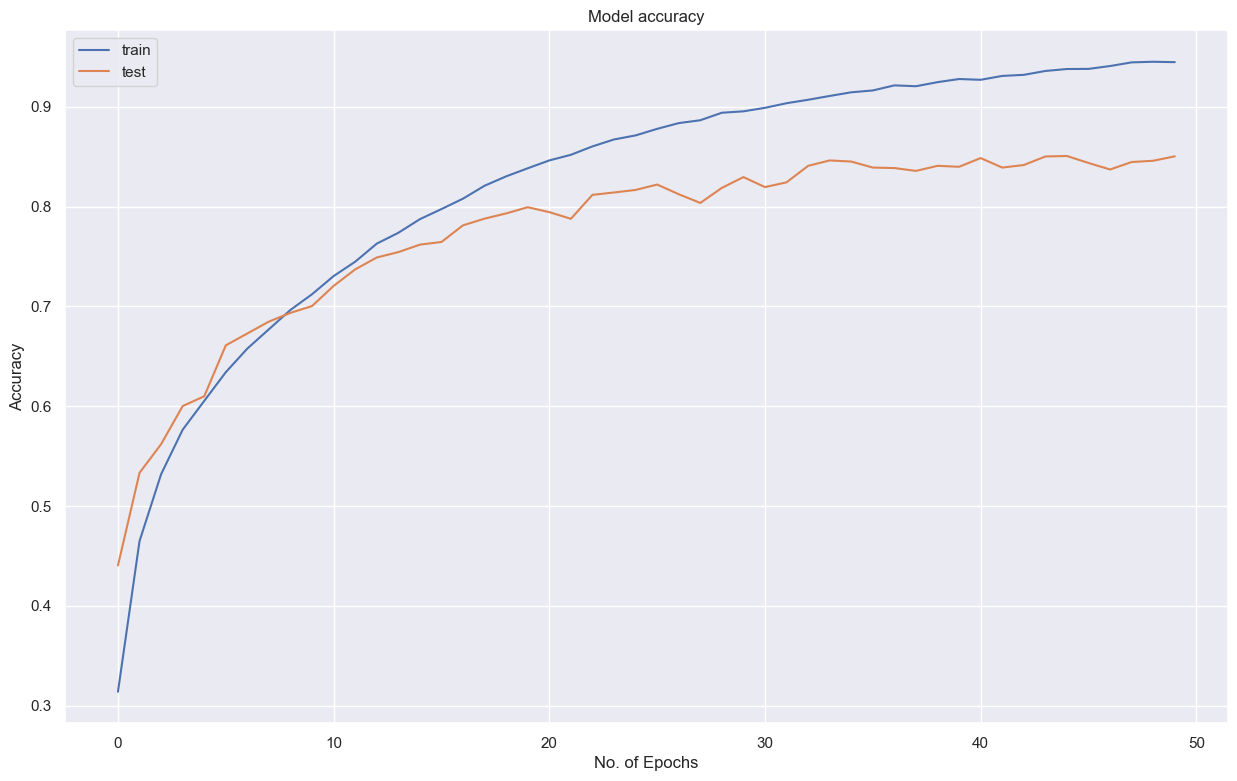

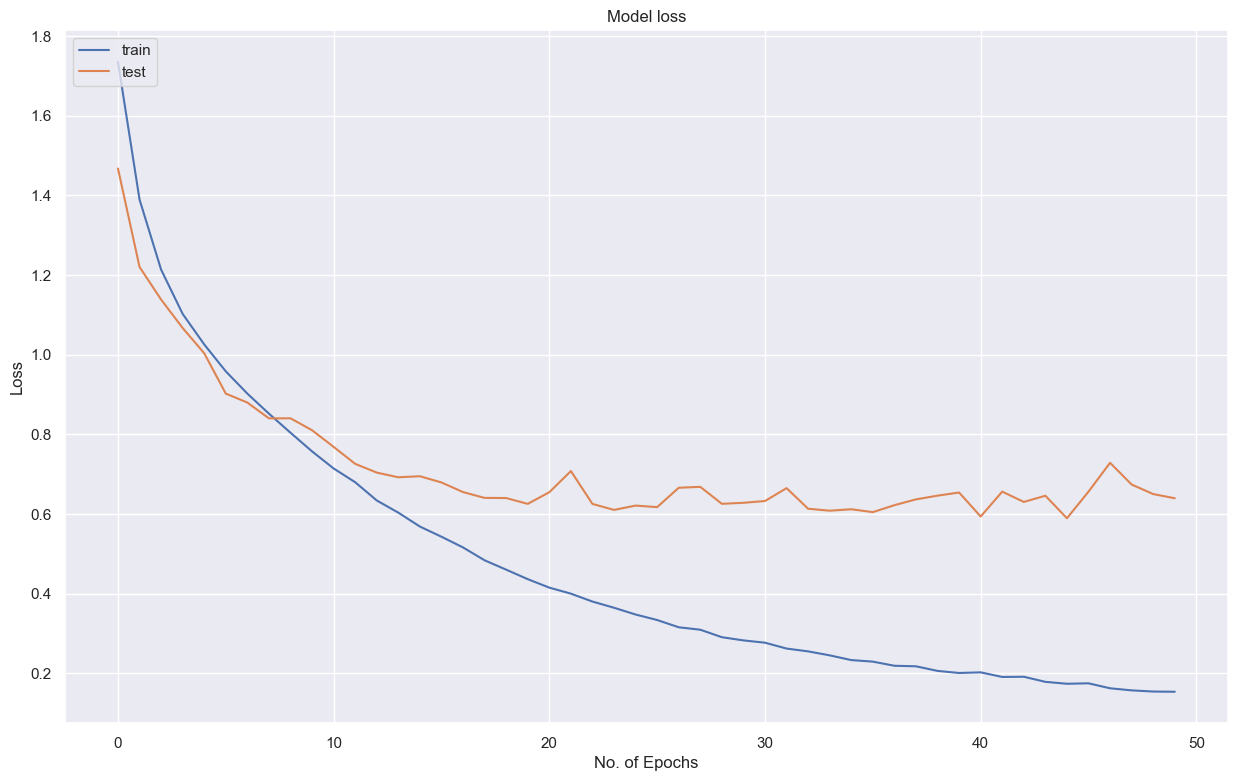

In [ ]:
plt.figure(figsize=(15, 9))

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(figsize=(15, 9))

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
model.save("Classsify.h5")

In [58]:
y_pred = model.predict(x_test)

197/197 [==============================] - 6s 30ms/step


In [64]:
y_pred = np.argmax(y_pred,axis=1)
y_pred.shape

(6293,)

In [ ]:
y_test = np.argmax(y_test,axis=1)
y_test.shape

(6293,)

<Axes: >

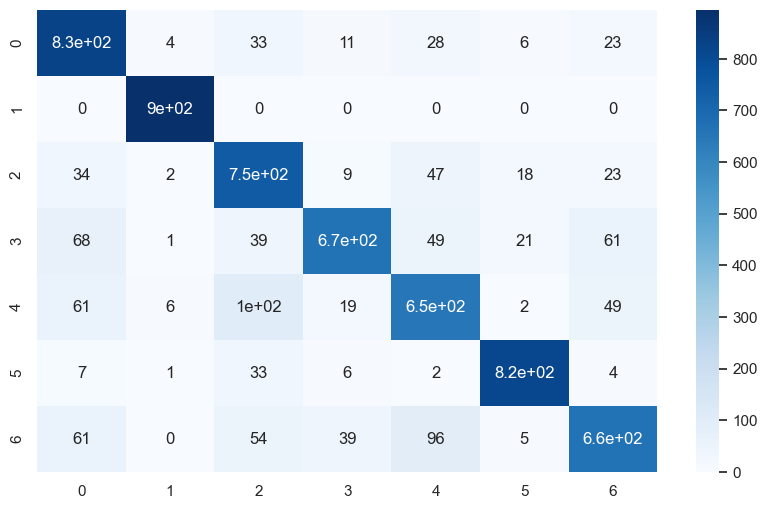

In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap="Blues")

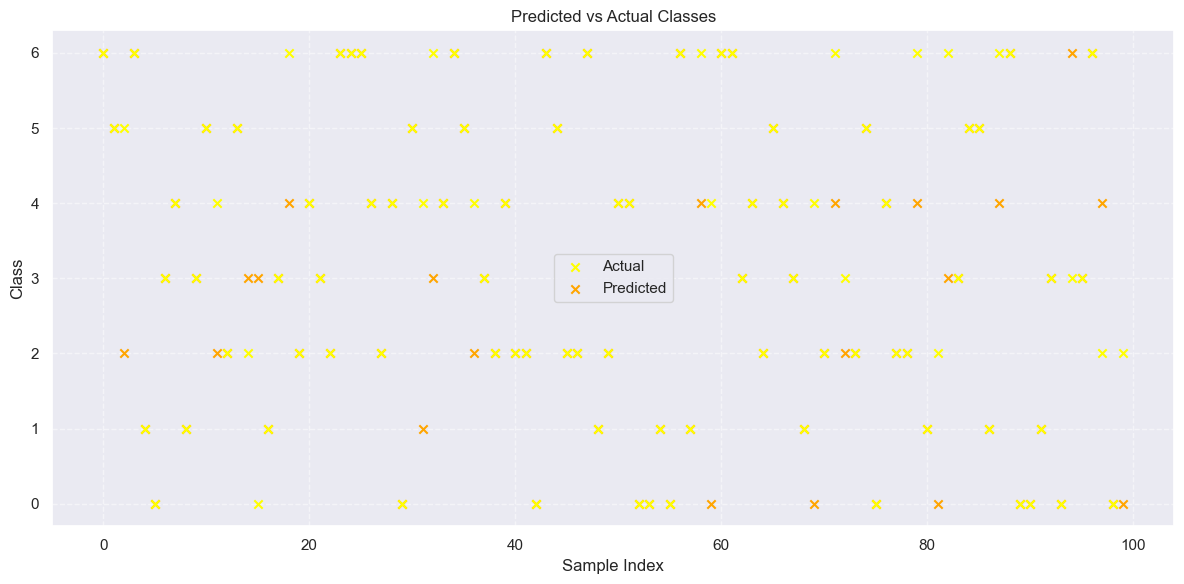

In [75]:
import matplotlib.pyplot as plt
import numpy as np

y_test = np.array(y_test[:100])
y_pred = np.array(y_pred[:100])
indices = np.arange(len(y_test))

plt.figure(figsize=(12, 6))
plt.scatter(indices, y_test, color='yellow', marker='x', label='Actual', zorder=2)
plt.scatter(indices, y_pred, color='orange', marker='x', label='Predicted', zorder=1)

plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.title('Predicted vs Actual Classes')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
